In [1]:
import iminuit
# import probfit
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy import optimize
import cProfile, pstats, StringIO
from multiprocessing import Pool
import pandas as pd

import atm_c14_data
import c14_models
import c14_individuals_data

reload(atm_c14_data)
reload(c14_models)
reload(c14_individuals_data);

atm_c14_data.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  c14_data = c14_data.sort('year')


In [2]:
Klag = atm_c14_data.Klag
K = atm_c14_data.K
C = c14_models.C_scenario_A
C2 = c14_models.C_scenario_2POP

c14_i_data = c14_individuals_data.c14_neu

c14_i_data_sigma = c14_i_data[ c14_i_data['Dbirth'] <= 1955.5 ]
sigma_estimate = c14_i_data_sigma['d14C'].std()

In [20]:
def neg_loglike_2POP(r, f, sigma_const, sigma_rel):
  loglike = 0
  for i, dataset in c14_i_data.iterrows():
    Dbirth = dataset['Dbirth']
    Dcoll = dataset['Dcoll']
    Cexp = dataset['d14C']
    
    sigma = sigma_const + sigma_rel * sp.absolute(C2(Dbirth, Dcoll, r, f))
    
    s1 = - 0.5 * (C2(Dbirth, Dcoll, r, f) - Cexp ) ** 2 / sigma ** 2
    s2 = - sp.log(sigma * sp.sqrt(2 * sp.pi))
    
    loglike += s1 + s2
  return -loglike

In [23]:
M_2POP_additive = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = 0.0066, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma_const = sigma_estimate, error_sigma_const = sigma_estimate / 10.0, limit_sigma_const = (0.0, None), fix_sigma_const = False,\
                   sigma_rel = 0.0, error_sigma_rel = 1.0, limit_sigma_rel = (0.0, None), fix_sigma_rel = True,\
                   print_level = 1)

In [26]:
M_2POP_additive.migrad()

FCN = -115.222982341 
 TOTAL NCALL = 158 
 NCALLS = 158 
 
 
 EDM = 2.83511476297e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,2.276185e-01,8.572852e-02,0.000000e+00,0.000000e+00,0.0,,
2,f,3.409095e-01,1.775516e-02,0.000000e+00,0.000000e+00,0.0,1.0,
3,sigma_const,2.977945e-02,2.839055e-03,0.000000e+00,0.000000e+00,0.0,,
4,sigma_rel,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,,FIXED


({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 0.5, 'edm': 2.835114762969939e-06, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': -115.2229823408633, 'nfcn': 158},
 [{'is_const': False, 'name': 'r', 'has_limits': True, 'value': 0.22761848073169277, 'number': 0, 'has_lower_limit': True, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 0.0857285214716823, 'is_fixed': False},
  {'is_const': False, 'name': 'f', 'has_limits': True, 'value': 0.34090945738424416, 'number': 1, 'has_lower_limit': True, 'upper_limit': 1.0, 'lower_limit': 0.0, 'has_upper_limit': True, 'error': 0.01775516239510544, 'is_fixed': False},
  {'is_const': False, 'name': 'sigma_const', 'has_limits': True, 'value': 0.029779446199261317, 'number': 2, 'has_lower_limit': True, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False

In [28]:
M_2POP_multi = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = 0.0066, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma_const = 0.0, error_sigma_const = sigma_estimate / 10.0, limit_sigma_const = (0.0, None), fix_sigma_const = True,\
                   sigma_rel = 0.001, error_sigma_rel = 0.0001, limit_sigma_rel = (0.0, None), fix_sigma_rel = False,\
                   print_level = 1)

In [29]:
M_2POP_multi.migrad();

FCN = -93.6531553775 
 TOTAL NCALL = 536 
 NCALLS = 536 
 
 
 EDM = 2.94879792827e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,1.433761e-02,2.474264e-04,0.000000e+00,0.000000e+00,0.0,,
2,f,3.468212e-01,2.367775e-02,0.000000e+00,0.000000e+00,0.0,1.0,
3,sigma_const,0.000000e+00,2.451849e-03,0.000000e+00,0.000000e+00,0.0,,FIXED
4,sigma_rel,7.486208e-01,9.182117e-02,0.000000e+00,0.000000e+00,0.0,,


In [10]:
print 'r: {0:.4f}'.format(M.values['r'])
print 'f: {0:.2f}'.format(M.values['f'])

r: 0.2276
f: 0.34


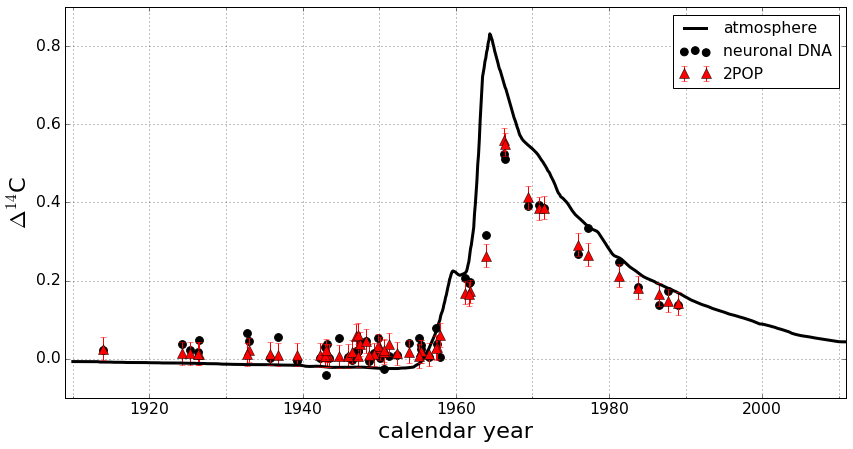

In [21]:
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rcParams.update({'xtick.labelsize': 'large'})
matplotlib.rcParams.update({'ytick.labelsize': 'large'})

f, ax = plt.subplots(1, 1)
f.set_figwidth(14)
f.set_figheight(7)

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'atmosphere', lw = 3, color = 'black')
ax.scatter(c14_i_data['Dbirth'], c14_i_data['d14C'], color = 'black', label = 'neuronal DNA', s = 60)
ax.errorbar(c14_i_data['Dbirth'], \
           sp.vectorize(C2)(c14_i_data['Dbirth'], c14_i_data['Dcoll'], M.values['r'], M.values['f']),\
            M.values['sigma_const'],
           color = 'red', label = '2POP', marker='^', ls = '', ms = 10)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
ax.grid(which='both')
ax.legend(loc='best', fontsize = 'large', frameon = True, framealpha = 1.0)

ax.set_xlabel('calendar year', fontsize = 'xx-large')
ax.set_ylabel('$\Delta^{14}$C', fontsize = 'xx-large')


plt.savefig('fit_2POP_neu.png', dpi = 300, bbox_inches='tight', transparent = True)
plt.show()

In [34]:
M.get_merrors()

{'f': {'lower_new_min': False, 'upper': 0.16062373645414, 'lower': -0.16053689944319463, 'at_lower_limit': False, 'min': 0.3408985219317755, 'at_lower_max_fcn': False, 'is_valid': True, 'upper_new_min': False, 'at_upper_limit': False, 'lower_valid': True, 'upper_valid': True, 'at_upper_max_fcn': False, 'nfcn': 357L},
 'sigma_const': {'lower_new_min': False, 'upper': 0.041016195294729926, 'lower': -0.012623517040189587, 'at_lower_limit': False, 'min': 0.029777065169439565, 'at_lower_max_fcn': False, 'is_valid': True, 'upper_new_min': False, 'at_upper_limit': False, 'lower_valid': True, 'upper_valid': True, 'at_upper_max_fcn': False, 'nfcn': 310L}}

In [9]:
# minos
print 'Minos 95%'
M.minos(var='f', sigma = 1.92);
M.minos(var='sigma_const', sigma = 1.92);

Minos 95%


Error,-0.0348254794337,0.0347938577006
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00471957407167,0.00641122051449
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [10]:
# minos profiles
#rprofile = M.draw_mnprofile('r', bins=160, bound = (0.1, 20.0), subtract_min = True)

rs = sp.sort(sp.hstack((sp.linspace(0.1, 10, 50), M.values['r'], 0.15)))
f_initial = M.values['f']
sigma_initial = M.values['sigma_const']
def fit_fix_r(r):
  M = iminuit.Minuit(neg_loglike, errordef = 0.5,\
                   r = r, error_r = 1e-3, limit_r = (0.0, None), fix_r = True,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma_const = sigma_const_initial, error_sigma_const = sigma_const_initial / 10.0, limit_sigma_const = (0.0, None), fix_sigma_const = False,\
                   sigma_rel = sigma_rel_initial, error_sigma_rel = sigma_rel_initial / 10.0, limit_sigma_rel = (0.0, None), fix_sigma_rel = True,\
                   print_level = 0)
  M.migrad()
  if M.migrad_ok():
    return M.fval
  else:
    return sp.nan

pool = Pool(processes=7) 
neglogL = sp.array(pool.map(fit_fix_r, rs))

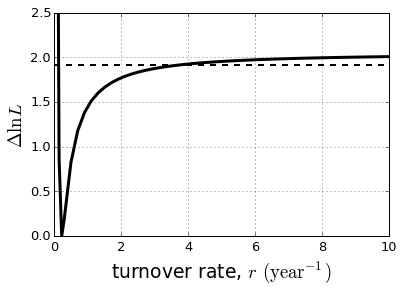

In [11]:
# matplotlib.rcParams['font.size'] = 12

plt.xlim(0, 10)
plt.ylim(0, 2.5)

plt.xlabel('turnover rate, $r$ $(\mathrm{year}^{-1})$', fontsize = 'x-large')
plt.ylabel('$\Delta \ln L$', fontsize = 'x-large')

plt.grid()

plt.plot(rs, neglogL-M.fval, 'black', lw = 3)
plt.plot([0, 10], [1.92, 1.92], 'k--', lw = 2)

plt.savefig('rprofile.png', dpi = 300, bbox_inches = 'tight', transparent=True)

plt.show()

Now find the minos errors

In [12]:
f = sp.interpolate.interp1d(rs, neglogL - neglogL.min() - 1.92) 

In [13]:
from scipy import optimize
rmin = sp.optimize.root(f, 0.1, method='lm')['x'].item()
rmax = sp.optimize.root(f, 2, method='lm')['x'].item()

print 'r:'
print '{0:.2f} (95\% CI [{1:.2f}, {2:.2f}])'.format(M.values['r'], rmin, rmax)


r:
0.23 (95\% CI [0.14, 3.83])


In [14]:
r = M.values['r']

f = M.values['f']
fmin = f + M.get_merrors()['f']['lower']
fmax = f + M.get_merrors()['f']['upper']

sigma_const = M.values['sigma_const']
sigma_constmin = sigma_const + M.get_merrors()['sigma_const']['lower']
sigma_constmax = sigma_const + M.get_merrors()['sigma_const']['upper']

print 'r:'
print '{0:.2f} (95\% CI [{1:.2f}, {2:.2f}])'.format(r, rmin, rmax)

print 'f:'
print '{0:.2f} (95\% CI [{1:.2f}, {2:.2f}])'.format(f, fmin, fmax)

print '\sigma (pro mille):'
print '{0:.0f}\permil (95\% CI [{1:.0f}\permil, {2:.0f}\permil])'.format(1e3 * sigma_const, 1e3 * sigma_constmin, 1e3 * sigma_constmax)

r:
0.23 (95\% CI [0.14, 3.83])
f:
0.34 (95\% CI [0.31, 0.38])
\sigma (pro mille):
30\permil (95\% CI [25\permil, 36\permil])


In [18]:
ML_2POP_results = pd.DataFrame()

ML_2POP_results.loc['r', 'estimate'] = r
ML_2POP_results.loc['r', 'min'] = rmin
ML_2POP_results.loc['r', 'max'] = rmax

ML_2POP_results.loc['f', 'estimate'] = f
ML_2POP_results.loc['f', 'min'] = fmin
ML_2POP_results.loc['f', 'max'] = fmax

ML_2POP_results.loc['sigma', 'estimate'] = sigma_const
ML_2POP_results.loc['sigma', 'min'] = sigma_constmin
ML_2POP_results.loc['sigma', 'max'] = sigma_constmax

ML_2POP_results.to_pickle('ML_2POP_results.pkl')
ML_2POP_results

,estimate,min,max
r,0.227625,0.136061,3.832547
f,0.340934,0.306108,0.375728
sigma,0.029781,0.025061,0.036192


In [ ]:
### parameter profiles

#print 'Drawing Profiles (no Minis Profiles!!!)'
#M.draw_profile('r', bins=20, bound = (0.1, 0.9), subtract_min = True)
#plt.show()
#M.draw_profile('f', bins=10, bound = (0.28, 0.4), subtract_min = True)
#plt.show()
#M.draw_profile('sigma_const', bins=10, bound = 2, subtract_min = True)
#plt.show()
#M.draw_profile('sigma_rel', bins=10, bound = 2, subtract_min = True)
#plt.show()

In [37]:
## contours
#M.draw_mncontour('r', 'f', nsigma = 4)
#plt.show()

# contour plot
x, y, g, r = M.mncontour_grid('r','f', bins = 50, nsigma=4, numpoints = 20, sigma_res = 4,edges = True)
matplotlib.rcParams['font.size'] = 14
plt.pcolormesh(x,y,g)
plt.colorbar()
plt.grid()

plt.xlim((0.1, 0.7))
plt.ylim((0.29, 0.39))

plt.xticks(sp.linspace(0.2, 0.6, 3, endpoint = True))
plt.yticks(sp.linspace(0.3, 0.38, 5, endpoint = True))

plt.xlabel('turnover rate, $r$ / $year^{-1}$', fontsize = 'x-large')
plt.ylabel('fraction renewing, $f$', fontsize = 'x-large')

plt.savefig('rfcontour_grid.png', dpi = 300, bbox_inches = 'tight', transparent=True)

/home/fabian/anaconda/lib/python2.7/site-packages/iminuit/_plotting.py:87: RuntimeWarning: Fail mncontour for r, f, sigma=0.100000
  warnings.warn(RuntimeWarning('Fail mncontour for %s, %s, sigma=%f'%(x,y,this_sig)))
/home/fabian/anaconda/lib/python2.7/site-packages/iminuit/_plotting.py:85: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              r = +nan
              f = +0.332023
    sigma_const = +0.030051
      sigma_rel = +0.000000

  sigma=this_sig)
/home/fabian/anaconda/lib/python2.7/site-packages/iminuit/_plotting.py:85: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              r = -nan
              f = +0.332023
    sigma_const = -nan
      sigma_rel = +0.000000

  sigma=this_sig)
/home/fabian/anaconda/lib/python2.7/site-packages/iminuit/_plotting.py:85: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              r = +nan
              f = +0.333245
    sigma_const = +0.030051
      sigma_rel 

RuntimeError: To use interp='nn' (Natural Neighbor interpolation) in griddata, natgrid must be installed.  Either install it from http://sourceforge.net/projects/matplotlib/files/matplotlib-toolkits, or use interp='linear' instead.

In [ ]:
## r f colormesh
#sigma_const_initial2 = M.values['sigma_const']
#rbins = 10
#rmin = 0.1
#rmax = 0.7
#rs = sp.linspace(rmin, rmax, rbins)

#fbins = 30
#fmin = 0.30
#fmax = 0.40
#fs = sp.linspace(fmin, fmax, fbins)

#g = sp.ma.empty((rbins, fbins))
#g.mask = True

#for i, r in enumerate(rs):
  #for j, f in enumerate(fs):
    #Mtemp = iminuit.Minuit(neg_loglike, errordef = 0.5, r = r, fix_r = True,  f=f, fix_f = True, sigma_const = sigma_const_initial2 , error_sigma_const = sigma_const_initial2 / 10.0, sigma_rel = sigma_rel_initial, error_sigma_rel = sigma_rel_initial / 10.0, fix_sigma_const = False, fix_sigma_rel = True,  print_level = 0, limit_sigma_rel = (0.0, None), limit_sigma_const = (0.0, None))
    #Mtemp.migrad()
    #if Mtemp.migrad_ok():
      #g[i, j] = Mtemp.fval
#g2 = g - g.min()